## UVA MSDS Capstone Project Step 4 Models
- This notebook demonstrates how to fit a simple LDA classifier using Sklearn
- This notebook demonstrates how to utilize TPOT Auto ML package within a Jupyter Lab Notebook
- This notebook demonstrates how to fit a random forest classifier using Sklearn
    - Implements K-Fold Cross Validation while fitting models
    - Includes a ROC plotting method for each fold
    - Extracts feature importance from Random forest models

## Loading Required Packages

In [2]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tpot import TPOTClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, Normalizer
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

## Methods used in analysis

In [3]:
def plot_roc_curve(fprs, tprs):
    """
    Referenced Yacine Nouri's method for plotting CV ROC plots
    Link to Yacine Nouri's Page: https://www.kaggle.com/code/ynouri/random-forest-k-fold-cross-validation
    """
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

## Creating the datasets
- Loading in genus counts tables
- Down sampling the control dataset to be ~ the size of diabetes and kidney respectively to use accuracy as our main classification metric
- Pulling the statistically different genera for diabetes and kidney respectively
- Creating train and test sets for diabetes and kidney respectively

In [4]:
# load genus table
genus_counts = pd.read_csv('count_files/genus_counts.csv')

# separate by condition
diabetes = genus_counts[genus_counts.diagnosis == 'diabetes']
kidney = genus_counts[genus_counts.diagnosis == 'kidney_disease']
control = genus_counts[genus_counts.diagnosis == 'control']
t1_diabetes = genus_counts[(genus_counts.diagnosis == 'diabetes') & (genus_counts.diabetes_type == "Type I diabetes")]
t2_diabetes = genus_counts[(genus_counts.diagnosis == 'diabetes') & (genus_counts.diabetes_type == "Type II diabetes")]

C:\Users\Capstone1\AppData\Local\Temp\2\ipykernel_8132\2929018162.py:2: DtypeWarning: Columns (0,816) have mixed types. Specify dtype option on import or set low_memory=False.
  genus_counts = pd.read_csv('count_files/genus_counts.csv')


In [5]:
## Using the following method again from the EDA notebook

def hypothesis_test(col1, col2):
    test = stats.ttest_ind(a=col1, b=col2)
    return test.pvalue

diabetes_sig = []
kidney_sig = []
t1_sig = []
t2_sig = []

for col in control.columns[1:810]:
    p_kid = hypothesis_test(control[col], kidney[col])
    p_diab = hypothesis_test(control[col], diabetes[col])
    p_t1 = hypothesis_test(control[col], t1_diabetes[col])
    p_t2 = hypothesis_test(control[col], t2_diabetes[col])
    
    if(p_kid < .05):
        kidney_sig.append(col)
    if(p_diab < .05):
        diabetes_sig.append(col)
    if(p_t1 < .05):
        t1_sig.append(col)
    if(p_t2 < .05):
        t2_sig.append(col)

In [6]:
# remove features that are indicators of either/both conditions
intersection = list(set(kidney_sig) & set(diabetes_sig))
new_kid = [x for x in kidney_sig if x not in intersection]
new_diab = [x for x in diabetes_sig if x not in intersection]

# type1 vs type2
intersection_types = list(set(t1_sig) & set(t2_sig))
t1 =[x for x in t1_sig if x not in intersection_types]
t2 =[x for x in t2_sig if x not in intersection_types]

In [7]:
# get relevant feature sets (including other disease states for now)
diab_feats = new_diab + list(control.columns[-28:])
diab_feats.remove('sample_type')
diab_feats.remove('sample_name')
diab_feats.remove('diabetes')
diab_feats.remove('diabetes_type')

kid_feats = new_kid + list(control.columns[-28:])
kid_feats.remove('sample_type')
kid_feats.remove('sample_name')
kid_feats.remove('kidney_disease')

t1_feats = t1 + list(control.columns[-28:])
t1_feats.remove('sample_type')
t1_feats.remove('sample_name')
t1_feats.remove('diabetes')
t1_feats.remove('diabetes_type')

t2_feats = t2 + list(control.columns[-28:])
t2_feats.remove('sample_type')
t2_feats.remove('sample_name')
t2_feats.remove('diabetes')
t2_feats.remove('diabetes_type')

In [8]:
# downsample control data to have as many entries as other data drames
control_diab = control.sample(n=len(diabetes), random_state=42, axis=0).reset_index().drop('level_0', axis=1)
control_kid = control.sample(n=len(kidney), random_state=42, axis=0).reset_index().drop('level_0', axis=1)
control_t1 = control.sample(n=len(t1_diabetes), random_state=42, axis=0).reset_index().drop('level_0', axis=1)
control_t2 = control.sample(n=len(t2_diabetes), random_state=42, axis=0).reset_index().drop('level_0', axis=1)

In [9]:
#recombine into single data frames
diab_df = control_diab.append(diabetes).reset_index().drop('level_0', axis=1)
kid_df = control_kid.append(kidney).reset_index().drop('level_0', axis=1)
t1_df = control_t1.append(t1_diabetes).reset_index().drop('level_0', axis=1)
t2_df = control_t2.append(t2_diabetes).reset_index().drop('level_0', axis=1)

C:\Users\Capstone1\AppData\Local\Temp\2\ipykernel_8132\627533110.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diab_df = control_diab.append(diabetes).reset_index().drop('level_0', axis=1)
C:\Users\Capstone1\AppData\Local\Temp\2\ipykernel_8132\627533110.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kid_df = control_kid.append(kidney).reset_index().drop('level_0', axis=1)
C:\Users\Capstone1\AppData\Local\Temp\2\ipykernel_8132\627533110.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t1_df = control_t1.append(t1_diabetes).reset_index().drop('level_0', axis=1)
C:\Users\Capstone1\AppData\Local\Temp\2\ipykernel_8132\627533110.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [10]:
# filter to only relevant features
diab_df = diab_df[diab_feats]
kid_df = kid_df[kid_feats]
t1_df = t1_df[t1_feats]
t2_df = t2_df[t2_feats]

In [11]:
## Only keeping the numeric count variables for feature dataframes
kid_features = kid_df[list(kid_df.columns[0:16])]
kid_labels = kid_df["diagnosis"]

diab_features = diab_df[list(diab_df.columns[0:56])]
diab_labels = diab_df["diagnosis"]

t1_features = t1_df[list(t1_df.columns[0:17])]
t1_labels = t1_df["diagnosis"]

t2_features = t2_df[list(t2_df.columns[0:17])]
t2_labels = t2_df["diagnosis"]

In [12]:
## Creating train/test split datasets for kidney and diabetes
seed = 69
train_percent = .9
test_percent = 1-train_percent
x_train_kid, x_test_kid, y_train_kid, y_test_kid = train_test_split(kid_features,
                                                                    kid_labels, 
                                                                    train_size=train_percent, 
                                                                    test_size=test_percent, 
                                                                    random_state = seed, 
                                                                    shuffle=True)
x_train_diab, x_test_diab, y_train_diab, y_test_diab = train_test_split(diab_features,
                                                                        diab_labels, 
                                                                        train_size=train_percent, 
                                                                        test_size=test_percent, 
                                                                        random_state = seed, 
                                                                        shuffle=True)
x_train_t1, x_test_t1, y_train_t1, y_test_t1 = train_test_split(t1_features,
                                                                t1_labels, 
                                                                train_size=train_percent, 
                                                                test_size=test_percent, 
                                                                random_state = seed, 
                                                                shuffle=True)
x_train_t2, x_test_t2, y_train_t2, y_test_t2 = train_test_split(t2_features,
                                                                t2_labels, 
                                                                train_size=train_percent, 
                                                                test_size=test_percent, 
                                                                random_state = seed, 
                                                                shuffle=True)

## Simple Implementation of LDA Classification Models 

#### LDA - Kidney

In [13]:
clf = LinearDiscriminantAnalysis()
lda_kidney = clf.fit(x_train_kid, y_train_kid)
y_pred = lda_kidney.predict(x_test_kid)
cm = confusion_matrix(y_test_kid, y_pred)
print("Kidney LDA Holdout Test Results")
print(cm)
print('Accuracy' + str(accuracy_score(y_test_kid, y_pred)))

Kidney LDA Holdout Test Results
[[22 11]
 [14 11]]
Accuracy0.5689655172413793


#### LDA - Diabetes

In [14]:
clf = LinearDiscriminantAnalysis()
lda_diab = clf.fit(x_train_diab, y_train_diab)
y_pred = lda_diab.predict(x_test_diab)
cm = confusion_matrix(y_test_diab, y_pred)
print("Diabetes LDA Holdout Test Results")
print(cm)
print('Accuracy' + str(accuracy_score(y_test_diab, y_pred)))

Diabetes LDA Holdout Test Results
[[29  6]
 [33 23]]
Accuracy0.5714285714285714


## Auto ML Examples (TPOT)

#### Kidney Auto ML

In [15]:
## TPOT optimizer needs labels in binary instead of labels
ylab_df = y_train_kid.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df)
y_train_kid_tpot = ylab_df['label']

          diagnosis  label
2           control      0
242         control      0
124         control      0
496  kidney_disease      1
86          control      0
..              ...    ...
561  kidney_disease      1
404  kidney_disease      1
439  kidney_disease      1
203         control      0
54          control      0

[518 rows x 2 columns]


In [16]:
## Creating an instance of TPOT optimization
tpot = TPOTClassifier(random_state = 124, scoring = "accuracy", generations = 200, n_jobs = -1, population_size = 150, verbosity = 2, max_eval_time_mins = 2)

In [17]:
## Uncomment the line below to create a TPOT optimized AutoML model
#tpot.fit(x_train_kid, y_train_kid_tpot)

In [18]:
## After fitting use a similar line like below to export the model framework (seen in next cell)
#tpot.export('tpot_best_model_200gens.py')

In [19]:
## Exported model that achieved .604 Cross Validated Accuracy using the training set after 200 model generations
# Average CV score on the training set was: 0.6043478260869566
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    Normalizer(norm="l1"),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.001, max_depth=9, max_features=0.25, min_samples_leaf=12, min_samples_split=17, n_estimators=100, subsample=0.5)),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=0.8, min_samples_leaf=12, min_samples_split=17, n_estimators=100, subsample=0.6500000000000001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 124)

exported_pipeline.fit(x_train_kid, y_train_kid_tpot)
results = exported_pipeline.predict(x_test_kid)


In [20]:
## TPOT optimizer needs labels in binary instead of labels
ylab_df2 = y_test_kid.to_frame()
ylab_df2['label'] = np.where(ylab_df2['diagnosis'].eq("control"), 0, 1)
print(ylab_df2.head())
y_test_kid_tpot = ylab_df2['label']

          diagnosis  label
101         control      0
3           control      0
31          control      0
150         control      0
573  kidney_disease      1


In [21]:
cm = confusion_matrix(y_test_kid_tpot, results)
print("Kidney Disease AutoML Hold out set results")
print(cm)
print('Accuracy' + str(accuracy_score(y_test_kid_tpot, results)))

Kidney Disease AutoML Hold out set results
[[22 11]
 [15 10]]
Accuracy0.5517241379310345


#### Diabetes Auto ML

In [22]:
## TPOT optimizer needs labels in binary instead of labels
ylab_df_diab = y_train_diab.to_frame()
ylab_df_diab['label'] = np.where(ylab_df_diab['diagnosis'].eq("control"), 0, 1)
print(ylab_df_diab)
y_train_diab_tpot = ylab_df_diab['label']

    diagnosis  label
724  diabetes      1
720  diabetes      1
148   control      0
696  diabetes      1
738  diabetes      1
..        ...    ...
439   control      0
602  diabetes      1
619  diabetes      1
203   control      0
54    control      0

[815 rows x 2 columns]


In [23]:
tpot_diab_150 = TPOTClassifier(random_state = 1, scoring = "accuracy", generations = 150, n_jobs = -1, population_size = 50, verbosity = 2, max_eval_time_mins = 5)

In [24]:
## Uncomment the line below to create a TPOT optimized AutoML model
#tpot_diab_150.fit(x_train_diab, y_train_diab_tpot)

In [25]:
## After fitting use a similar line like below to export the model framework (seen in next cell)
#tpot_diab_150.export('tpot_best_model_150gens_diab.py')

In [26]:
## Exported model that achieved .629 Cross Validated Accuracy using the training set after 150 model generations
# Average CV score on the training set was: 0.6294478527607362
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        StackingEstimator(estimator=MultinomialNB(alpha=1.0, fit_prior=False))
    ),
    StackingEstimator(estimator=XGBClassifier(learning_rate=1.0, max_depth=6, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=0.1, verbosity=0)),
    StackingEstimator(estimator=SGDClassifier(alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=0.75, learning_rate="invscaling", loss="hinge", penalty="elasticnet", power_t=0.5)),
    XGBClassifier(learning_rate=0.1, max_depth=1, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

exported_pipeline.fit(x_train_diab, y_train_diab_tpot)
results = exported_pipeline.predict(x_test_diab)


C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
C:\Miniconda\envs\py38_default\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


In [27]:
## TPOT optimizer needs labels in binary instead of labels
ylab_df_diab = y_test_diab.to_frame()
ylab_df_diab['label'] = np.where(ylab_df_diab['diagnosis'].eq("control"), 0, 1)
print(ylab_df_diab)
y_test_diab_tpot = ylab_df_diab['label']

    diagnosis  label
99    control      0
519  diabetes      1
540  diabetes      1
544  diabetes      1
545  diabetes      1
..        ...    ...
378   control      0
91    control      0
299   control      0
7     control      0
381   control      0

[91 rows x 2 columns]


In [28]:
cm = confusion_matrix(y_test_diab_tpot, results)
print("Kidney Disease AutoML Hold out set results")
print(cm)
print('Accuracy' + str(accuracy_score(y_test_diab_tpot, results)))

Kidney Disease AutoML Hold out set results
[[19 16]
 [21 35]]
Accuracy0.5934065934065934


## Random Forest
- The majority of the notebook and time was spent making an interactive notebook for Random Forest Models
- CLF Cells are displayed in a way to easily adjust parameters
- K-Fold Cross Validation ROC plot for each fold
- AUC scores displayed for training and testing in each folder
- Feature importance at genera level for each model displayed

#### Kidney Disease Random Forest Module

          diagnosis  label
2           control      0
242         control      0
124         control      0
496  kidney_disease      1
86          control      0
..              ...    ...
561  kidney_disease      1
404  kidney_disease      1
439  kidney_disease      1
203         control      0
54          control      0

[518 rows x 2 columns]


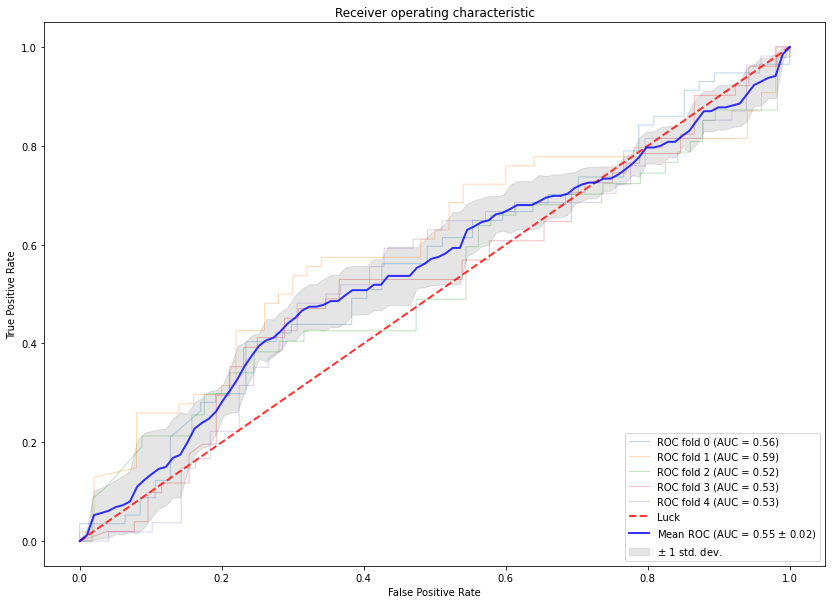

,AUC Train,AUC Test
0,0.645724,0.555431
1,0.637869,0.592778
2,0.630986,0.524263
3,0.614753,0.530354
4,0.637049,0.534580


In [164]:
## Adjust the parameters to your liking
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=1,
    min_samples_split=2,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_features=15,
    max_leaf_nodes=None,
    #min_impurity_decrease=0.0,
    #min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

## Setting up K-Fold
cv = KFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

## Creating Binary Label
ylab_df = y_train_kid.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df)
y_train_binary_kid = ylab_df['label']

## Fitting the model and creating the plots
X = x_train_kid
y = y_train_binary_kid

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [165]:
## Predicting on holdout set
y_pred= clf.predict(x_test_kid)

## Creating binary label
ylab_df = y_test_kid.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df.head())
y_test_binary_kid = ylab_df['label']

          diagnosis  label
101         control      0
3           control      0
31          control      0
150         control      0
573  kidney_disease      1


In [166]:
cm = confusion_matrix(y_test_binary_kid, y_pred)
print("Your Random Forest model for Kidney Disease results on hold out set are below:")
print(cm)
print('Accuracy' + str(accuracy_score(y_test_binary_kid, y_pred)))

Your Random Forest model for Kidney Disease results on hold out set are below:
[[21 12]
 [16  9]]
Accuracy0.5172413793103449


In [169]:
## Feature importances from the CV model stored as importances 
importances = list(clf.feature_importances_)
## Feature names stored as feats
feats = list(clf.feature_names_in_)
## Importance dataframe
imp_df = pd.DataFrame(list(zip(feats, importances)), columns = ["Feature", "Importance"]).sort_values("Importance", ascending = False)
## Display DF
imp_df.head(10)

,Feature,Importance
0,Lachnospira,0.677
12,Tyzzerella_4,0.082
9,Lachnospiraceae_UCG-001,0.072
1,Ruminococcus_2,0.063
3,Lachnospiraceae_NK4A136_group,0.039
7,Shuttleworthia,0.029
2,Coprococcus_2,0.017
11,Anaeroplasma,0.009
15,Defluviitaleaceae_UCG-011,0.008
8,Lachnospiraceae_UCG-003,0.004


Text(0.5, 1.0, 'Top 10 Feature Importances by Feature - Kidney Disease Random Forest')

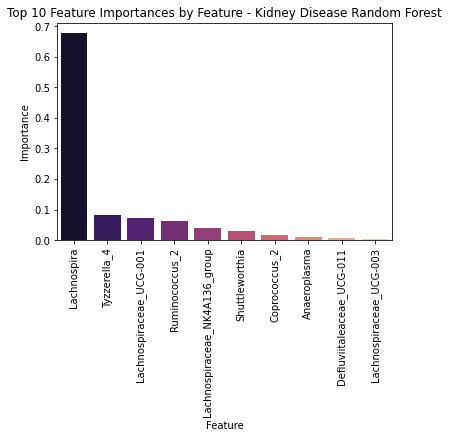

In [170]:
sns.barplot(x = 'Feature', y = 'Importance',
           data = imp_df.head(10), palette="magma")
plt.xticks(rotation=90)
plt.title("Top 10 Feature Importances by Feature - Kidney Disease Random Forest")

#### Diabetes Random Forest module

    diagnosis  label
724  diabetes      1
720  diabetes      1
148   control      0
696  diabetes      1
738  diabetes      1
..        ...    ...
439   control      0
602  diabetes      1
619  diabetes      1
203   control      0
54    control      0

[815 rows x 2 columns]


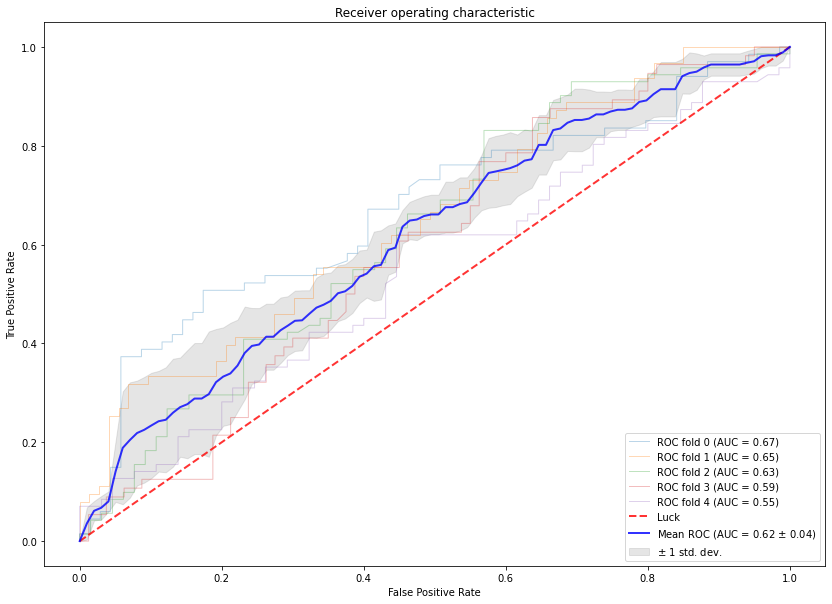

,AUC Train,AUC Test
0,0.687319,0.670452
1,0.674577,0.652751
2,0.696206,0.626761
3,0.688607,0.591629
4,0.691614,0.551463


In [172]:
## Adjust the parameters to your liking
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=1,
    min_samples_split=2,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_features=50,
    max_leaf_nodes=None,
    #min_impurity_decrease=0.0,
    #min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

cv = KFold(n_splits=6, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

ylab_df = y_train_diab.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df)
y_train_binary_diab = ylab_df['label']

X = x_train_diab
y = y_train_binary_diab

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [173]:
y_pred= clf.predict(x_test_diab)

ylab_df = y_test_diab.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df.head())
y_test_binary_diab = ylab_df['label']

    diagnosis  label
99    control      0
519  diabetes      1
540  diabetes      1
544  diabetes      1
545  diabetes      1


In [174]:
cm = confusion_matrix(y_test_binary_diab, y_pred)
print("Your Random Forest model for Diabetes results on hold out set are below:")
print(cm)
print('Accuracy' + str(accuracy_score(y_test_binary_diab, y_pred)))

Your Random Forest model for Diabetes results on hold out set are below:
[[25 10]
 [33 23]]
Accuracy0.5274725274725275


In [175]:
## Feature importances from the CV model stored as importances 
importances = list(clf.feature_importances_)
## Feature names stored as feats
feats = list(clf.feature_names_in_)
## Importance dataframe
imp_df = pd.DataFrame(list(zip(feats, importances)), columns = ["Feature", "Importance"]).sort_values("Importance", ascending = False)
## Display DF
imp_df.head(10)

,Feature,Importance
8,Clostridium_sensu_stricto_1,0.281
48,Acidaminococcus,0.198
16,Lachnoclostridium,0.192
10,Akkermansia,0.123
19,Coprococcus_1,0.079
35,Desulfovibrio,0.035
5,Bacteroides,0.026
14,Alistipes,0.018
7,Collinsella,0.014
18,Megasphaera,0.013


Text(0.5, 1.0, 'Top 10 Feature Importances by Feature - Diabetes Random Forest')

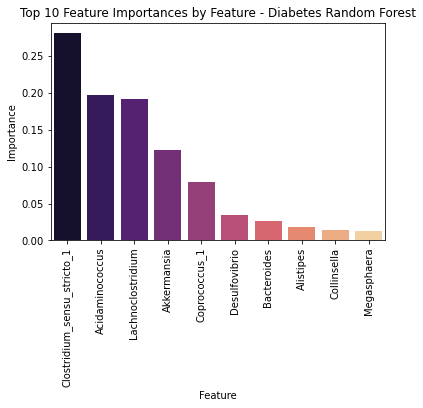

In [176]:
## Plotting feature importance information
sns.barplot(x = 'Feature', y = 'Importance',
           data = imp_df.head(10), palette="magma")
plt.xticks(rotation=90)
plt.title("Top 10 Feature Importances by Feature - Diabetes Random Forest")

## Type 1 / Type 2 Diabetes vs Control
- This section investigates whether or not Type 1 Diabetes Microbiomes have different indicators compared to Type 2 Diabetes when attempting to classify against a control group

#### Type 1 Diabetes Module

   diagnosis  label
31   control      0
10   control      0
17   control      0
57  diabetes      1
83  diabetes      1
..       ...    ...
55  diabetes      1
90  diabetes      1
73  diabetes      1
75  diabetes      1
54  diabetes      1

[93 rows x 2 columns]


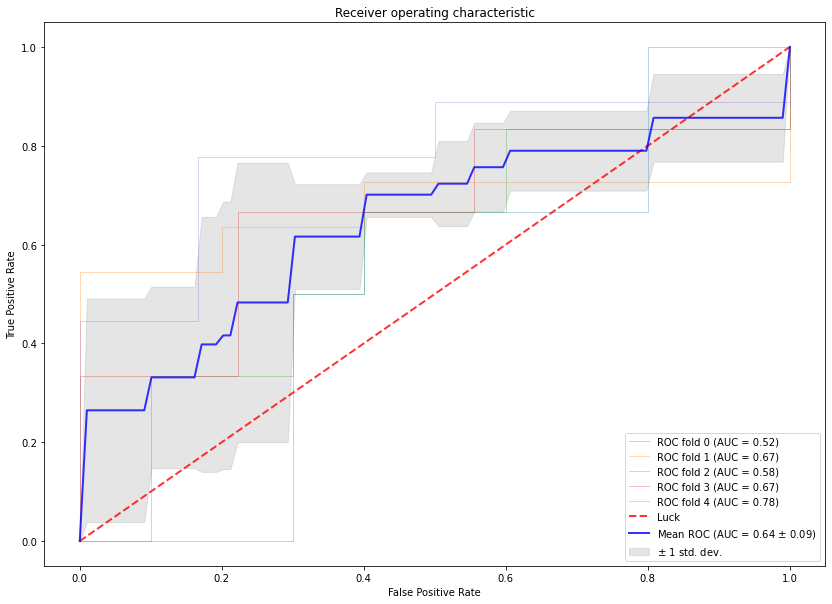

,AUC Train,AUC Test
0,0.774390,0.516667
1,0.726965,0.672727
2,0.725271,0.583333
3,0.771918,0.666667
4,0.730263,0.777778


In [178]:
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=1,
    min_samples_split=2,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_features=15,
    max_leaf_nodes=None,
    #min_impurity_decrease=0.0,
    #min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

cv = KFold(n_splits=6, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

ylab_df = y_train_t1.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df)
y_train_binary_t1 = ylab_df['label']

X = x_train_t1
y = y_train_binary_t1

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [179]:
## Feature importances from the CV model stored as importances 
importances = list(clf.feature_importances_)
## Feature names stored as feats
feats = list(clf.feature_names_in_)
## Importance dataframe
imp_df = pd.DataFrame(list(zip(feats, importances)), columns = ["Feature", "Importance"]).sort_values("Importance", ascending = False)
## Display DF
imp_df.head(10)

,Feature,Importance
1,Faecalibacterium,0.498
2,Butyricimonas,0.174
3,Roseburia,0.138
11,Barnesiella,0.103
7,Turicibacter,0.048
15,Succinivibrio,0.035
5,Brucella,0.004
0,Actinobacillus,0.000
14,Alcaligenes,0.000
13,Zoogloea,0.000


Text(0.5, 1.0, 'Top 10 Feature Importances by Feature - Type 1 Random Forest')

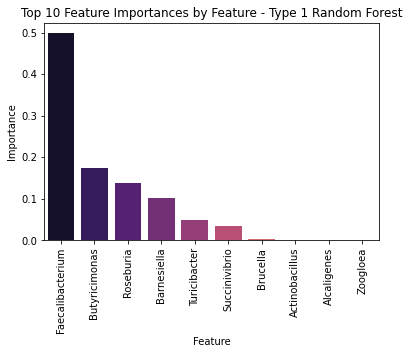

In [180]:
## Plotting feature importance information
sns.barplot(x = 'Feature', y = 'Importance',
           data = imp_df.head(10), palette="magma")
plt.xticks(rotation=90)
plt.title("Top 10 Feature Importances by Feature - Type 1 Random Forest")

#### Type 2 Diabetes Module

    diagnosis  label
229   control      0
3     control      0
228   control      0
446  diabetes      1
5     control      0
..        ...    ...
90    control      0
107   control      0
457  diabetes      1
203   control      0
54    control      0

[435 rows x 2 columns]


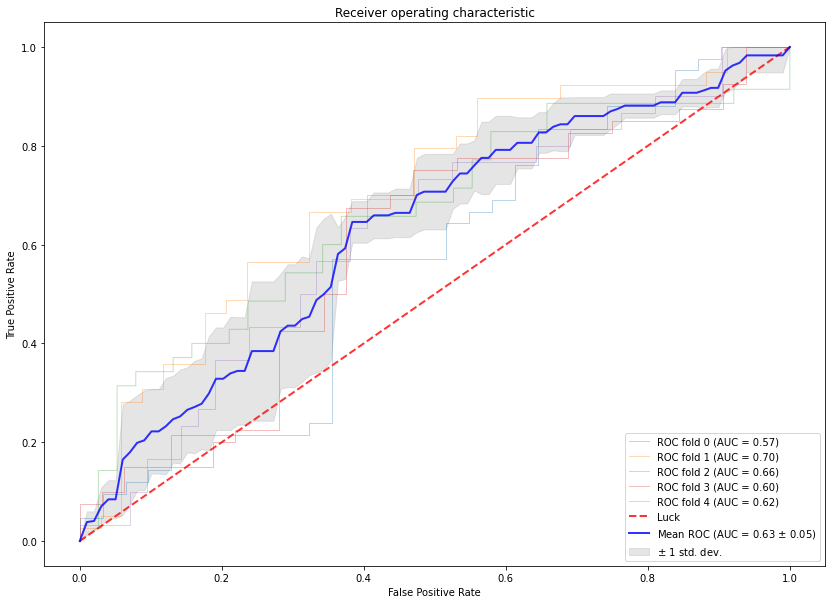

,AUC Train,AUC Test
0,0.694790,0.568356
1,0.674417,0.701357
2,0.680026,0.657519
3,0.690832,0.596094
4,0.682063,0.623016


In [182]:
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=1,
    min_samples_split=2,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_features=15,
    max_leaf_nodes=None,
    #min_impurity_decrease=0.0,
    #min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

cv = KFold(n_splits=6, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

ylab_df = y_train_t2.to_frame()
ylab_df['label'] = np.where(ylab_df['diagnosis'].eq("control"), 0, 1)
print(ylab_df)
y_train_binary_t2 = ylab_df['label']

X = x_train_t2
y = y_train_binary_t2

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [183]:
## Feature importances from the CV model stored as importances 
importances = list(clf.feature_importances_)
## Feature names stored as feats
feats = list(clf.feature_names_in_)
## Importance dataframe
imp_df = pd.DataFrame(list(zip(feats, importances)), columns = ["Feature", "Importance"]).sort_values("Importance", ascending = False)
## Display DF
imp_df.head(10)

,Feature,Importance
14,Parasutterella,0.489
16,Bilophila,0.127
11,Collinsella,0.107
0,Streptococcus,0.107
13,Akkermansia,0.061
7,Fusobacterium,0.057
9,Blautia,0.027
15,Oscillibacter,0.015
2,Brevibacterium,0.005
1,Pseudomonas,0.003


Text(0.5, 1.0, 'Top 10 Feature Importances by Feature - Type 2 Random Forest')

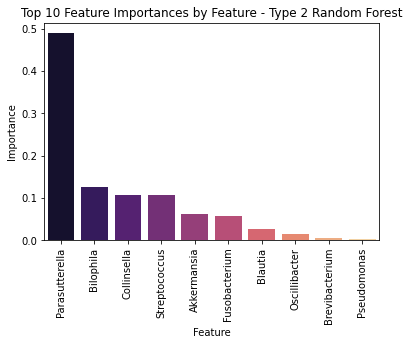

In [184]:
## Plotting feature importance information
sns.barplot(x = 'Feature', y = 'Importance',
           data = imp_df.head(10), palette="magma")
plt.xticks(rotation=90)
plt.title("Top 10 Feature Importances by Feature - Type 2 Random Forest")